<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Beta-Variational-Autoencoder-Using-Keras-data-Dsprites" data-toc-modified-id="Beta-Variational-Autoencoder-Using-Keras-data-Dsprites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Beta Variational Autoencoder Using Keras data Dsprites</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Description-of-the-dataset" data-toc-modified-id="Description-of-the-dataset-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Description of the dataset</a></span></li><li><span><a href="#Generating-the-Training-and-test-data" data-toc-modified-id="Generating-the-Training-and-test-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Generating the Training and test data</a></span></li></ul></li><li><span><a href="#Building-the-Beta-VAE" data-toc-modified-id="Building-the-Beta-VAE-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Building the Beta-VAE</a></span><ul class="toc-item"><li><span><a href="#Beta-VAE-Summary" data-toc-modified-id="Beta-VAE-Summary-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Beta-VAE Summary</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Traversals" data-toc-modified-id="Traversals-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Traversals</a></span></li></ul></li></ul></li></ul></div>

# Beta Variational Autoencoder Using Keras data Dsprites

The code is based on the book [Generative Deep Learning by David Foster](https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/).

## Data

The data is taken from [Dsprites dataset](https://github.com/deepmind/dsprites-dataset). 

For loading the dataset we used this [notebook](https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb).

The datafiles are on the input folder.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os

# Change figure aesthetics
%matplotlib inline
sns.set_context('paper', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [2]:
path = os.getcwd()
dataset_zip = np.load(path+'/input/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
                     ,encoding='bytes', allow_pickle=True)

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]


print('Metadata: \n', metadata)

Keys in the dataset: KeysView(<numpy.lib.npyio.NpzFile object at 0x7f502574eb38>)
Metadata: 
 {b'date': b'April 2017', b'description': b'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', b'version': 1, b'latents_names': (b'color', b'shape', b'scale', b'orientation', b'posX', b'posY'), b'latents_possible_values': {b'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22

### Description of the dataset

From the metadata we have the description of the dataset and how it was generated:

    'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.'

The latent space size for generating the dataset is:

    - 'latents_sizes': array([ 1,  3,  6, 40, 32, 32]), 

Each latent affect only one attribute of the figure, the atributes are:

    - 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
    
**Therefore, we have only one color, 3 shapes, 6 types of scales, 40 points regarding rotations, 32 points for the posX (or posY).**

In [3]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata[b'latents_sizes']

In [4]:
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

Generating helper functions to handle the data

In [5]:
def latent_to_index(latents):    
    return np.dot(latents, latents_bases).astype(int)

def ytest_to_index(latents):
    """Creating ytest index for posX feature.
    
    Parameters:
    -----------------------------------------
    latents(list): Latents.
    
    """
    return np.dot(latents,[0,0,0,0,1,0]).astype(int)

def sample_latent(size=1):
    """Sample the latent space.
    
    Parameters:
    -----------------------------------------
    size(integer): Number of samples.
    
    """
    
    samples = np.zeros((size, latents_sizes.size))
    
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

### Generating the Training and test data

Here we generate the dataset randomly.

In [6]:
# Sample latents randomly 
latents_sampled = sample_latent(size=5000)

# Select images
indices_sampled = latent_to_index(latents_sampled)

#To use as an index for the scatterplot (posX)
y_test = ytest_to_index(latents_sampled)

imgs_sampled = imgs[indices_sampled]

x_test = imgs[indices_sampled]
x_test = x_test.reshape(x_test.shape + (1,))

In [7]:
# Sample latents randomly
latents_sampled_train = sample_latent(size=30000)

# Select images
indices_sampled_train = latent_to_index(latents_sampled_train)
imgs_sampled = imgs[indices_sampled]

x_train = imgs[indices_sampled_train]
x_train = x_train.reshape(x_train.shape + (1,))

In [8]:
print('Analysing the shapes:\n'+ 
      ' X train shape: {} \n Y test shape: {} \n X test shape: {} \n'.format(x_train.shape,
                                                                               y_test.shape,
                                                                               x_test.shape))

Analysing the shapes:
 X train shape: (30000, 64, 64, 1) 
 Y test shape: (5000,) 
 X test shape: (5000, 64, 64, 1) 



## Building the Beta-VAE

*In this notebook I will ignore Furure and Deprecation Warnings*

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [10]:
from Models.VAE_Keras import VariationalAutoencoder_Keras

Using TensorFlow backend.


**Choose 'build' if you want to train the VAE, if you want to reload weights type 'reconstruct'.**

In [104]:
import os 

# run params
SECTION = 'bvae'
RUN_ID = '0001'
DATA_NAME = 'D'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build'

In [105]:
#Latent size
ZDIM = 10

bvae = VariationalAutoencoder_Keras(   
      input_dim = (64,64,1)
    , encoder_conv_filters = [32,64,64,64]#, 64]
    , encoder_conv_kernel_size = [3,3,3,3]#,3]
    , encoder_conv_strides = [1,2,2,1]#,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = ZDIM
)

if mode == 'build':
    bvae.save(RUN_FOLDER)
else:
    bvae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

### Beta-VAE Summary

In [106]:
bvae.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [107]:
bvae.decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16384)             180224    
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 64)        0         
__________

## Training

In [122]:
#Compile Parameters (These parameters depend on a fine tuning) 

LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 5000
BETA = 10

In [123]:
bvae.compile(LEARNING_RATE, R_LOSS_FACTOR, BETA)

In [124]:
# Training Parameters

BATCH_SIZE = 126

EPOCHS = 20

PRINT_EVERY_N_BATCHES = 100

INITIAL_EPOCH = 0

In [125]:
bvae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
          )

Epoch 1/20
30000/30000 [==============================] - 510s 17ms/step - loss: 140.6081 - vae_r_loss: 101.5043 - vae_kl_loss: 3.9104

Epoch 00001: saving model to run/bvae/0001_D/weights/weights-001-140.61.h5

Epoch 00001: saving model to run/bvae/0001_D/weights/weights.h5
Epoch 2/20
30000/30000 [==============================] - 508s 17ms/step - loss: 126.2686 - vae_r_loss: 78.4650 - vae_kl_loss: 4.7804

Epoch 00002: saving model to run/bvae/0001_D/weights/weights-002-126.27.h5

Epoch 00002: saving model to run/bvae/0001_D/weights/weights.h5
Epoch 3/20
30000/30000 [==============================] - 509s 17ms/step - loss: 123.2918 - vae_r_loss: 74.7729 - vae_kl_loss: 4.8519

Epoch 00003: saving model to run/bvae/0001_D/weights/weights-003-123.29.h5

Epoch 00003: saving model to run/bvae/0001_D/weights/weights.h5
Epoch 4/20
30000/30000 [==============================] - 511s 17ms/step - loss: 120.1351 - vae_r_loss: 71.3680 - vae_kl_loss: 4.8767

Epoch 00004: saving model to run/bvae/0

## Analysis

### Traversals

We choose a random point on the latent space that corresponds to an image.

In [126]:
n_to_show = 1

example_idx = np.random.choice(range(len(x_test)), n_to_show)

example_images = x_test[example_idx]

z_points = bvae.encoder.predict(example_images)

reconst_images = bvae.decoder.predict(z_points)


In [127]:
def traverse(pos,traverse_value,latent_vector):
    """Make the traverse on pos at the latent
    vector
    
    Parameters
    ------------------------------------------
    pos(int): Position at the latent vector that 
              you want to traverse.
    latent_vector(list): Latent vector.
    
    """
    latent_vector[0][pos] = traverse_value
    
    return latent_vector        

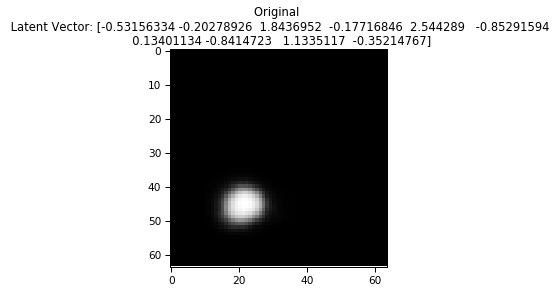

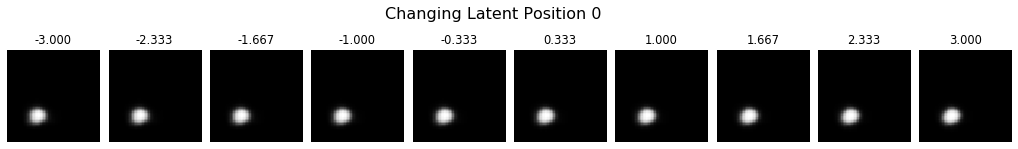

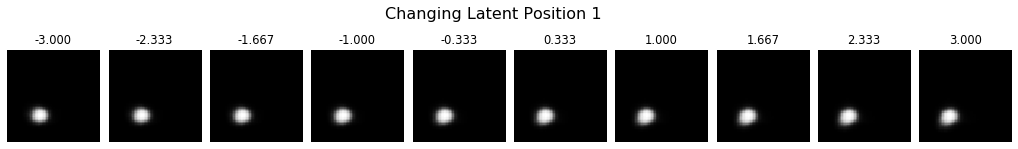

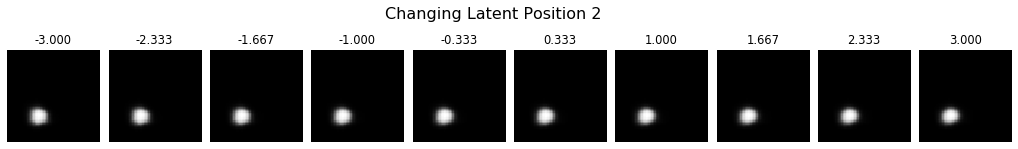

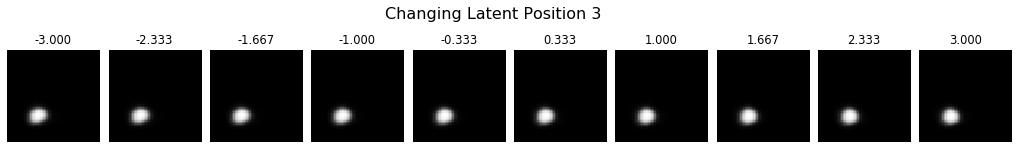

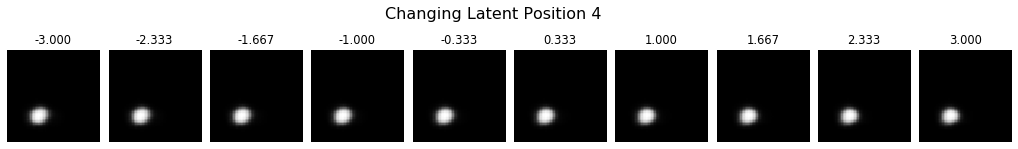

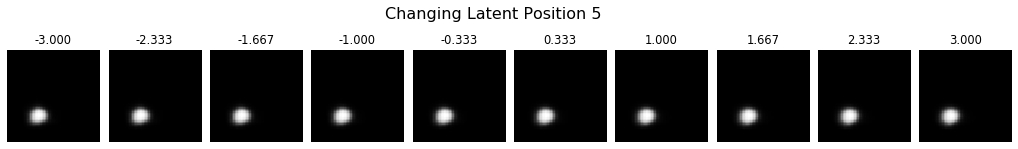

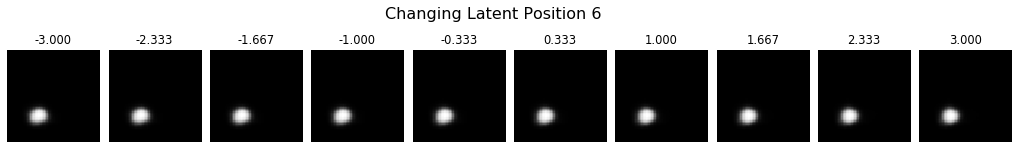

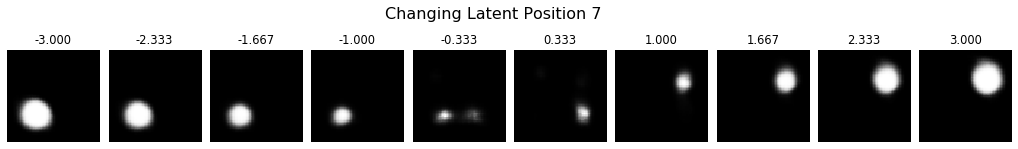

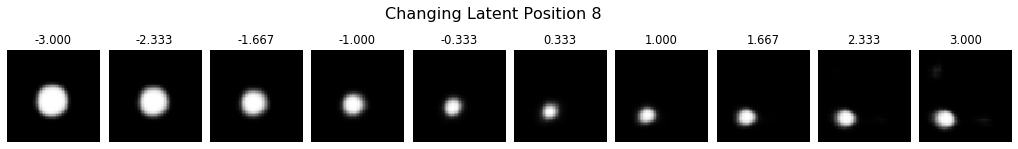

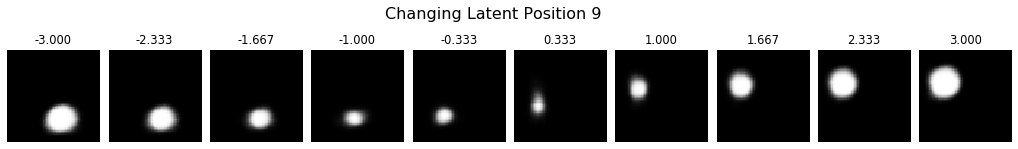

In [128]:
from copy import copy

#number of imgs
n_traverse = 10

#minimum value of traversal
min_t = -3

#maximum value of traversal
max_t = 3

plt.imshow(reconst_images[0,:,:,0], cmap='gray')
plt.title("Original \n Latent Vector: {}".format(z_points[0]))

for j in range(ZDIM):
    
    fig = plt.figure(figsize=(18,5))
    fig.subplots_adjust(hspace=0.4,wspace=0.1)    
    
    for i,val in enumerate(np.linspace(min_t,max_t,n_traverse)):
        #Use copy in order to not overwrite z_points
        Latent_T = traverse(j,val,copy(z_points)) 
        reconst_image = bvae.decoder.predict(Latent_T)
        ax = fig.add_subplot(1, n_traverse, i+1)
        ax.imshow(reconst_image[0,:,:,0], cmap='gray')
        ax.axis('off')
        ax.set_title("{:.3f}".format(val))
    fig.suptitle('Changing Latent Position {}'.format(j),x=0.5,y=0.75, fontsize=16)
    
    plt.show()